## Adapting the 1DHT model from Hornum et al. (2020) from MATLAB to Python and changing material properties to fit Ceres.

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
from line_profiler import LineProfiler

### Constants and Material Properties

In [4]:
toyr =60*60*24*365     # to year from s

            # Thermal properties of water and ice (from Williams and Smith, 1989) %%%
            
p_w = 1000             # density [kg/m3]
cp_w = 4180            # specific heat capacity [J/(kg*K)]
k_w = 0.56*toyr # thermal conductivity [(J/yr)/(m K)]
## NOTE TO MYSELF BC THIS HAS ALWAYS CONFUSED ME: normally, k is in units of W/mK (i.e., J/smK)
## by multipling by the number of seconds in a year, the units get turned to J/(yr m K), so that one we multiply by our timestep
## (1/20 yr), units cancel nicely to J/mK

p_ice = 917
cp_ice = 2100
k_ice = 2.24*toyr
L=333.6*1000           # Latent heat of fusion [J/kg]

#Julie paper

#silicate rock
p_rock = 2430
cp_rock = 2000
k_rock = 2 * toyr

#hydrated salt — not using this bc salt is being represented thru SFC Hydrohalite Schofield et al. 2014
p_salt = 2200
cp_salt = 920
k_salt = 0.6 * toyr

#p_boulder = (0.56*p_hyd)+(0.25*p_rock)+(0.19*p_salt)
#cp_boulder = (0.56*cp_hyd)+(0.25*cp_rock)+(0.19*cp_salt)
#k_boulder = (0.56*k_hyd)+(0.25*k_rock)+(0.19*k_salt)


            ## Porosity and thermal properties of CERES materials ##
            
n_Sc=1                 # Porosity scenario is chosen here: 1=minimum n, 2=intermediate n, 3=maximum n
nLob=[0.33, 0.45, 0.55, 0.66]    ## [min interm. max] Lobate (thermal model; 6B) ##
nIce = [0, 0.2, 0.4] # Lee et al. 2005
nQall=[0.3, 0.4, 0.5]    # [min interm. max]
nSndall=[0.06, 0.1, 0.15]
nShall=[0.08, 0.19, 0.3]

nQ = nQall[n_Sc]        
p_soilQ = 2400                     
cp_soilQ = 850    
k_soilQ = 0.5*toyr                 
aQ=k_soilQ/(p_soilQ*cp_soilQ)

nSnd =nSndall[n_Sc]       
p_soilSnd =2600                 
cp_soilSnd =900
k_soilSnd =2.5*toyr
aSnd=k_soilSnd/(p_soilSnd*cp_soilSnd)

nSh =nShall[n_Sc]
p_soilSh =2600
cp_soilSh =800
k_soilSh =1.5*toyr
aSh=k_soilSh/(p_soilSh*cp_soilSh)


                    ### Material 1 - Lobate
#matrix material: clay (silicate ONLY)
nL = nLob[n_Sc]   
nI = nIce[n_Sc]
p_soilL = p_rock       ## DENSITY (thermal model; 2B)             
cp_soilL = cp_rock       ## HEAT CAPACITY; GRAB FROM JULIE'S DATABASE (this is going to be tricky with temperature dependence)    
k_soilL = k_rock   ## THERMAL CONDUCTIVITY; GRAB FROM JULIE'S DATABASE (40% ice, 25% hydrates)       
aQ=k_soilL/(p_soilL*cp_soilL) #THERMAL DIFFUSIVITY [m^2/yr]


            ### Model parameters ###
tstep=0.05         # time step [yr] this is the minimum time step with our material properties
ts_1yr=1/tstep     # number of time steps in a year; 20
dz=2               # cell size [m]
grid_depth=600     ## grid depth, GRID SPANS 600m (depth of lobate flow) (domain constraints; 5B)
z=np.arange(0,grid_depth+dz,dz) # cell nodes, 0,2,4,6 M ETC.
nocell=len(z)    # number of cells
w = 0.957725 #Hornum SFC constant
print(nocell)

301


### Hornum 2020 Model Validation

In [3]:
Kv=273.15               # set to -273.15 if in Kelvin. 0 if in C
T_gradient=1/40    # Thermal gradient
T_0=0+Kv           # Initial surface temperature - NOT USED if temperature reconstruction is defined
T_end=grid_depth*T_gradient+Kv # Initial temperature at bottom of grid - NOT USED in for loop
T_ini=z*T_gradient+Kv # Initial temperature distribution
T=np.zeros(nocell)

TCurve_data=pd.read_csv('/Users/alexiakubas/Desktop/Ceres/1DHT_clone/-1DHT-model-code/HoloceneTemperatureCurve.txt', header=None) # 'HoloceneTemperatureCurve.txt' should be placed in same folder as this script
T_ann10 = TCurve_data[1] + 273.15 #temperatures, dep variable
tt_yr = TCurve_data[0] #years, indep variable

ttt = np.arange(0, 11000+tstep, tstep) #do this for maximum runtime, can filter down later
interp_function = interp1d(tt_yr, T_ann10, kind='linear', fill_value='extrapolate')

T_ann10q = interp_function(ttt)    #These temperatures are used in the model for-loop
print(T_ann10q)
print(T_ini - 273.15)

[277.15    277.15    277.15    ... 278.4601  278.46005 278.46   ]
[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15
  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75
  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15  2.2   2.25  2.3   2.35
  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75  2.8   2.85  2.9   2.95
  3.    3.05  3.1   3.15  3.2   3.25  3.3   3.35  3.4   3.45  3.5   3.55
  3.6   3.65  3.7   3.75  3.8   3.85  3.9   3.95  4.    4.05  4.1   4.15
  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35
  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75  5.8   5.85  5.9   5.95
  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35  6.4   6.45  6.5   6.55
  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95  7.    7.05  7.1   7.15
  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55  7.6   7.

### Ceres Initial Temperature Profile

In [5]:
#Kv= -273.15              # set to -273.15 if in Kelvin. 0 if in C
T_gradient=0.00273    ## Thermal gradient [K/m] (Raymond et al. 2020) (thermal model; 7B)
#T_0=273           # Initial surface temperature - NOT USED if temperature reconstruction is defined
#T_end=350 # Initial temperature at bottom of grid - NOT USED in for loop (estimate from Bowling)
T_ini=np.zeros(nocell) # Initial temperature distribution, gives every cell node a temperature
for i in range(nocell):
    #if 0 <= i < 2:
    #    T_ini[i] = 150.00
    #elif 2 <= i < (nocell-1)/2:
    #    T_ini[i] = T_ini[i-1] + 0.821 #K/m
    #elif i == (nocell-1)/2:
    #    T_ini[i] = 273.15
    #elif i > (nocell-1)/2:
    #    T_ini[i] = T_ini[i-1] - 0.821
    #elif i == grid_depth-1:
    #    T_ini[i] = 150.00
    #else:
    #    T_ini_1[i] = 300.00
    T_ini[i] = 273.15

#T_ini = [round(item, 3) for item in T_ini_1] #rounding all floats to the nearest hundredth to match with interpolated SFC
print(T_ini)

[273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.1

### Ceres temperature reconstruction—for top temperature boundary condition

In [6]:
# Ceres temperature reconstruction (just a .txt file) with 100k rows each with a temp of 150 K
# Load the data from the text file

TCurve_data = pd.read_csv('cerestempcurve.txt', header=None)
#TCurve_data = pd.read_csv('cerestempcurve_rampeddown.csv', header=None)

T_ann10 = TCurve_data[1] #temperatures, dep variable
tt_yr = TCurve_data[0] #years, indep variable

ttt = np.arange(0, 100000+tstep, tstep) #do this for maximum runtime, can filter down later
interp_function = interp1d(tt_yr, T_ann10, kind='linear', fill_value='extrapolate')

T_ann10q = interp_function(ttt) #interpolating the surface temperature so there is one for every time step
#print(T_ann10q)

### Defining functions for fw and dfw for different SFCs

In [7]:
# Use these functions for SFC equation from Sizemore et al. (2015)
#T_f = 0.01050 #0.55 porosity
T_f = 0.05102 #0.45 porosity
beta = 0.254

def calculate_fw_Siz(T, T_f, beta):
    if T >= 273.15-T_f:
        return 1.0  # Water is fully liquid
    elif 265 <= T < 273.15-T_f:
        return (T_f / (273.15 - T)) ** beta
    elif 240 <= T < 265:
        return (0.011024*T) - 2.64576 #0.45 porosity
        #return (0.00738*T) - 1.7712 #0.55 porosity
    elif T < 240:
       return 0.0 #Water is fully frozen

def calculate_dfw_Siz(T, T_f, beta):
    if T >= 273.15-T_f:
        return 0.0  # No change in liquid water fraction above melting point
    elif 265 <= T < 273.15-T_f:
        return (beta * T_f**beta) / ((273.15 - T) ** (beta + 1))
    elif 240 <= T < 265:     
        return 0.011024 #0.45 porosity
        #return 0.00738 #0.55 porosity
    elif T < 240:
        return 0.0 #Water is fully frozen

In [8]:
# Use these functions for SFC equation from Hesse & Castillo (2018)
def calculate_fw_HC(T):
    if T >= 273.15:
        return 1.0  # Water is fully liquid
    elif 245 <= T < 273.15:
        return (1/28.15)*(T-245)
    elif T < 245:
        return 0.0 #Water is fully frozen
        

def calculate_dfw_HC(T):
    if T >= 273.15:
        return 0.0  # No change in liquid water fraction above melting point
    elif 245 <= T < 273.15:
        return (1/28.15)
    elif T < 245:
        return 0.0 #Water is fully frozen

In [9]:
# Use these functions for SFC equation from Hornum et al. (2020)
def calculate_fw_Hornum(T):
    if T >= 273.15:
        return 1.0  # Water is fully liquid
    else:
        return np.exp(-((T-273.15)/w)**2)
        

def calculate_dfw_Hornum(T):
    if T >= 273.15:
        return 0.0  # No change in liquid water fraction above melting point
    else:
        return -2 * (T-273.15) * np.exp(-((T-273.15) / w) ** 2)

/var/folders/q6/f8_x77hj45d1kngmhhrc3k9r0000gn/T/ipykernel_3853/2757683964.py:7: RuntimeWarning: invalid value encountered in power
  plt.plot(test_temps[1650:1732], (0.05102 / ((273.15-0.05102) - test_temps[1650:1732])) ** beta, c='red')


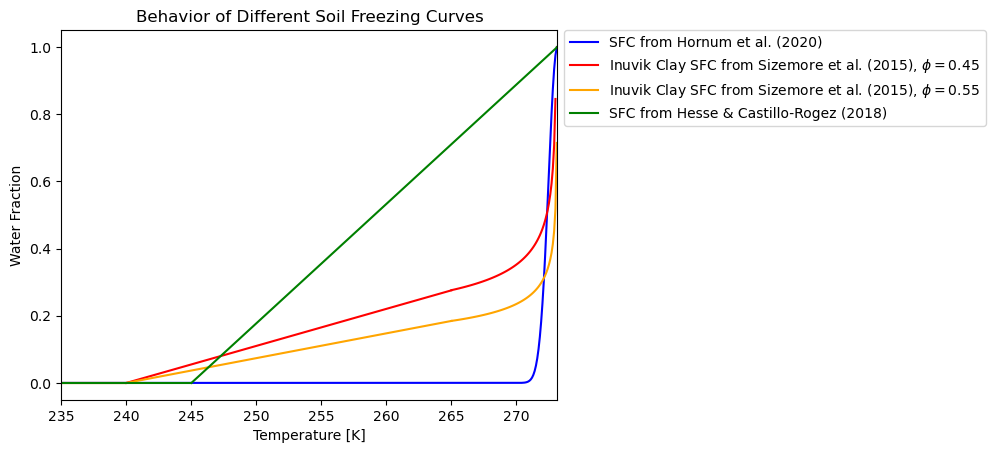

In [10]:
test_temps = np.arange(100,300.1,.1)
plt.plot(test_temps[0:1732], np.exp(-((test_temps[0:1732]-273.15)/w)**2), c='blue', label="SFC from Hornum et al. (2020)")
plt.plot(test_temps[1731:], np.ones(len(test_temps[1731:])), c='blue')

plt.plot(test_temps[0:1401], np.zeros(len(test_temps[0:1401])), c='red', label=r'Inuvik Clay SFC from Sizemore et al. (2015), $\phi = 0.45$ ')
plt.plot(test_temps[1400:1651], (.011024*test_temps[1400:1651]) - 2.64576, c='red')
plt.plot(test_temps[1650:1732], (0.05102 / ((273.15-0.05102) - test_temps[1650:1732])) ** beta, c='red')
plt.plot(test_temps[1731:], np.ones(len(test_temps[1731:])), c='red')

plt.plot(test_temps[0:1401], np.zeros(len(test_temps[0:1401])), c='orange', label=r'Inuvik Clay SFC from Sizemore et al. (2015), $\phi = 0.55$ ')
plt.plot(test_temps[1400:1651], (0.00738*test_temps[1400:1651]) - 1.7712, c='orange')
plt.plot(test_temps[1650:1732], (0.01050 / ((273.15-0.01050) - test_temps[1650:1732])) ** beta, c='orange')
plt.plot(test_temps[1731:], np.ones(len(test_temps[1731:])), c='orange')

plt.plot(test_temps[0:1451], np.zeros(len(test_temps[0:1451])), c='green', label='SFC from Hesse & Castillo-Rogez (2018)')
plt.plot(test_temps[1450:1732], (1/28.15)*(test_temps[1450:1732]-245), c='green')
plt.plot(test_temps[1731:], np.ones(len(test_temps[1731:])), c='green')

plt.xlabel('Temperature [K]')
plt.ylabel('Water Fraction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.87))
plt.title('Behavior of Different Soil Freezing Curves')
plt.xlim(235,273.15)

# Set the desired DPI (dots per inch)
dpi = 300

# Save the plot as a PNG file
#plt.savefig('/Users/alexiakubas/Desktop/Ceres/modelruns/SFC_plot.png', dpi=dpi, bbox_inches='tight')

In [11]:
np.where(np.isclose(test_temps, 273.15, atol=0.11))[0]

array([1731, 1732])

In [12]:
test_temps[1739]

273.8999999999901

### Assigning material IDs to different columns and defining runtime

In [13]:
# 1=Lobate 2=Boulders 3=Ice
onegrid=np.ones(nocell) # 1 x 301 matrix

            #Hornum validation
#Z0_1MatID=np.ones(nocell) #1=Q
#Z0_1MatID[30:79]=2 #2=sandstone
#Z0_1MatID[80:nocell]=3 #3=shale

                # Material IDs ZONEs
Z0_1MatID=np.ones(nocell)
#Z0_1MatID[0]=3
#Z0_1MatID[1]=3
#Z0_1MatID[291:]=2 #boulders (bottom 20m)

#Z1_2MatID=np.ones(nocell)
#Z1_2MatID[0]=3
#Z1_2MatID[1]=3
#Z1_2MatID[251:]=2 #boulders (bottom 100m)

            ### Creating one-vectors and empty matrices used in for-loop ###
n_grid=np.zeros(nocell) # all of these have nocell elements -> all material properties define at nodes (1 x nocell matrix)
p_soil=np.zeros(nocell)
cp_soil=np.zeros(nocell)
k_soil=np.zeros(nocell)

df_w=np.zeros(nocell) ## CHANGE IN fraction of water in pore space
k_eq=np.zeros(nocell) ## EQUIVALENT THERMAL CONDUCTIVITY
C_eq=np.zeros(nocell)  ## EQUIVALENT HEAT CAPACITY
a_eq=np.zeros(nocell)  ## EQUIVALENT THERMAL DIFFUSIVITY

runtime = 6000

T_matx_0_1=np.zeros((nocell,runtime)) ### CREATING EMPTY TEMP MATRICES FOR EACH ZONE'S RUN TIME (100000 yr)
T_matx_0_1[:,0] = np.copy(T_ini)                                    ### add more as needed
T_matx_1_2=np.zeros((nocell,runtime))
T_matx_1_2[:,0] = np.copy(T_ini)
print(Z0_1MatID)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Initializing fraction arrays using desired SFC

In [14]:
# First, initialize the fraction arrays
F_w = np.zeros(nocell)
F_ice = np.zeros(nocell)
f_w = np.zeros(nocell)
f_ice = np.zeros(nocell)
F_soil = np.zeros(nocell)

for i in range(nocell): #len(T_ini) = nocell
    if T_ini[i] >= 273.15:
        f_w[i] = 1
    else:
        #f_w[i] = calculate_fw_HC(T_ini[i]) #Hesse & Castillo (2018)
        #f_w[i] = calculate_fw_Siz(T_ini[i], T_f, beta) #Sizemore et al. (2015)
        f_w[i] = calculate_fw_Hornum(T_ini[i]) #Hornum SFC

#using f_w values, assign initial values of other fraction arrays
for i in range(nocell):
    f_ice[i] = 1 - f_w[i]
    F_soil[i] = 1 - nL
    F_w[i] = f_w[i] * nL
    F_ice[i] = f_ice[i] * nL
    

#column-specific ice fraction arrays
f_matx_0_1=np.zeros((nocell,runtime))
f_matx_0_1[:,0] = np.copy(f_w)
f_matx_1_2=np.zeros((nocell,runtime))
f_matx_1_2[:,0] = np.copy(f_w)

print(f_w)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
for i in range(nocell):
    k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (F_w[i] * np.sqrt(k_w)) + (F_ice[i] * np.sqrt(k_ice))) ** 2
    C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (F_w[i] * p_w * cp_w) + (F_ice[i] * p_ice * (cp_ice + L * df_w[i]))
    a_eq[i] = k_eq[i] / C_eq[i]

k_eq_matx = np.zeros((nocell, runtime))
C_eq_matx = np.zeros((nocell, runtime))
a_eq_matx = np.zeros((nocell, runtime))

k_eq_matx[:,0] = np.copy(k_eq)
C_eq_matx[:,0] = np.copy(C_eq)
a_eq_matx[:,0] = np.copy(a_eq)

print(k_eq_matx)

[[3576182.4       0.        0.  ...       0.        0.        0. ]
 [3576182.4       0.        0.  ...       0.        0.        0. ]
 [3576182.4       0.        0.  ...       0.        0.        0. ]
 ...
 [3576182.4       0.        0.  ...       0.        0.        0. ]
 [3576182.4       0.        0.  ...       0.        0.        0. ]
 [3576182.4       0.        0.  ...       0.        0.        0. ]]


### The numerical model. Code for column 2 is commented out.

In [16]:
### Numerical Model ###
from line_profiler import LineProfiler

# Create a LineProfiler object
profiler = LineProfiler()
@profiler
def model_run():
    start_time = time.time()

    col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
    for col in col_incl:
        if col==1:            ### Defining the column in use
            runtime=6000      # Simulation runtime
            materialid=np.copy(Z0_1MatID)
        elif col==2:            ### Defining the column in use
            runtime=500      # Simulation runtime
            materialid=np.copy(Z1_2MatID)

        material_properties = {1: (nL, p_soilL, cp_soilL, k_soilL),\
                               2: (nSnd, p_soilSnd, cp_soilSnd, k_soilSnd),\
                               3: (nSh, p_soilSh, cp_soilSh, k_soilSh)}

        for ii in range(nocell):
            if materialid[ii] in material_properties:
                n_grid[ii], p_soil[ii], cp_soil[ii], k_soil[ii] = material_properties[materialid[ii]]
            else:
                print('error')

        no_tstep = int(runtime / tstep)  # Total number of time steps, DIFFERENT FOR EACH ZONE

        T_11 = np.copy(T_ann10q[:no_tstep + 1])  # Cutting temperature curve to simulation period
        T_11 = np.flip(T_11)  # New T_1

        ### stability criterion ###
        # calculates the effective thermal diffusivity of the soil and ice material
        # if stability < 0.5, model will proceed
        k_s_ice = ((n_grid * np.sqrt(k_ice)) + ((1-n_grid) * np.sqrt(k_soil))) ** 2
        C_s_ice = (n_grid * p_ice * cp_ice) + ((1 - n_grid) * p_soil * cp_soil)
        a_s_ice = k_s_ice / C_s_ice
        stability = (np.max(a_s_ice) * tstep / dz**2)

        #temperature array used in numerical model
        T = np.zeros((nocell, no_tstep))
        T[:, 0] = np.copy(T_ini)

        ### heat transfer loop starts
        if col==1:
            xT_ini = np.copy(T_ini)
            k = 0 #time step count
            l = 0 #year count
            for t in range(no_tstep):
                if stability > 0.5:
                    print('stability is:', stability)
                    break
                k += 1
                for i in range(1, nocell-1): #excluding top and bottom bc they have boundary conditions
                    if xT_ini[i] < 100: #sanity check 
                        print("year =", l, 'time step =', k)
                        print("cell number:", i, "temperature:", xT_ini[i])
                        print("water fraction =", f_w[i], "dfw =", df_w[i])
                        break
                    if xT_ini[i] >= 273.15:
                        f_w[i] = 1
                    else:
                        #f_w[i] = calculate_fw_HC(xT_ini[i])
                        #f_w[i] = calculate_fw_Siz(xT_ini[i], T_f, beta) #Sizemore et al. (2015)
                        f_w[i] = calculate_fw_Hornum(xT_ini[i]) #Hornum SFC

                    f_ice[i] = 1 - f_w[i]
                    F_w[i] = f_w[i] * n_grid[i]
                    F_ice[i] = f_ice[i] * n_grid[i]
                    
                    if xT_ini[i] >= 273.15:
                        df_w[i] = 0
                    else:
                        #df_w[i] = calculate_dfw_HC(xT_ini[i])
                        df_w[i] = calculate_dfw_Siz(xT_ini[i], T_f, beta) #Sizemore et al. (2015)
                        #df_w[i] = calculate_dfw_Hornum(xT_ini[i]) #Hornum SFC

                    #calculating equivalent material properties
                    k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (F_w[i] * np.sqrt(k_w)) + (F_ice[i] * np.sqrt(k_ice))) ** 2
                    C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (F_w[i] * p_w * cp_w) + (F_ice[i] * p_ice * (cp_ice + L * df_w[i]))
                    a_eq[i] = k_eq[i] / C_eq[i]

                    #if (xT_ini[i + 1] - xT_ini[i - 1]) != 0:
                    T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
                    #else:
                     #   T[i, t] = xT_ini[i]
    
                    T[0, t] = T_11[k + (l*20)] #setting the top temp to B.C. from csv file
                    #T[0, t] = 50
                    
                    #f_w[0] = calculate_fw_HC(xT_ini[0])
                    #f_w[0] = calculate_fw_Siz(xT_ini[0], T_f, beta) #Sizemore et al. (2015)
                    f_w[0] = calculate_fw_Hornum(xT_ini[0]) #Hornum SFC
                    
                    T[nocell - 1, t] = T[nocell - 2, t] + (dz * T_gradient) # constant flux BC
                
                    #f_w[nocell-1] = calculate_fw_HC(xT_ini[nocell-1])
                    #f_w[nocell-1] = calculate_fw_Siz(xT_ini[-1], T_f, beta) #Sizemore et al. (2015)
                    f_w[nocell-1] = calculate_fw_Hornum(xT_ini[nocell-1]) #Hornum SFC

                xT_ini = np.copy(T[:, t])    ### Value used in loop

                  ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
                f_w_0_1=np.copy(f_w)
                f_ice_0_1=np.copy(f_ice)

                 ### Creating a matrix with the temperature distribution for each year
                if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
                    if l != runtime:
                        ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                        # updates column of T matrix w temps from time step at the end of each year
                        T_matx_0_1[:,l]=np.copy(T[:,t])     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
                        f_matx_0_1[:,l]=np.copy(f_w)
                        k_eq_matx[:,l] = np.copy(k_eq)
                        C_eq_matx[:,l] = np.copy(C_eq)
                        a_eq_matx[:,l] = np.copy(a_eq)
                        l+=1 # INCREASE TO NEXT YEAR
                        k=0
                    elif l == runtime:
                        l += 1
                        k = 0

    
    print('complete')
    end_time = time.time()
    elapsed_time = (end_time - start_time) / 60 
    print(f"Elapsed time: {elapsed_time} minutes")

In [ ]:
model_run()

In [15]:
profiler.print_stats()

Timer unit: 1e-09 s

Total time: 58.858 s
File: /var/folders/q6/f8_x77hj45d1kngmhhrc3k9r0000gn/T/ipykernel_47267/2149429736.py
Function: model_run at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @profiler
     7                                           def model_run():
     8         1       7000.0   7000.0      0.0      start_time = time.time()
     9                                           
    10         1       1000.0   1000.0      0.0      col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
    11         2       1000.0    500.0      0.0      for col in col_incl:
    12         1       1000.0   1000.0      0.0          if col==1:            ### Defining the column in use
    13         1          0.0      0.0      0.0              runtime=500      # Simulation runtime
    14   

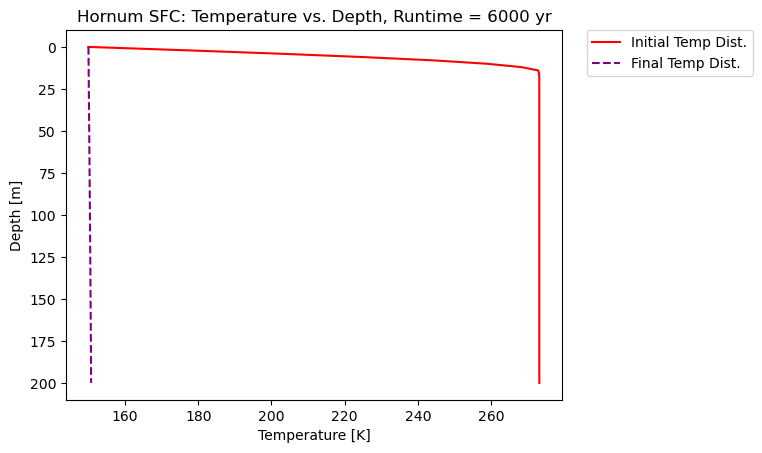

In [34]:
### Fig - Final temperature distrubution
#plotting curves for initial and final temp distributions

plt.figure()
#plt.xlim([100,400])
#plt.ylim(-.1,40)
plt.plot(T_matx_0_1[:,1], z,color='red', label='Initial Temp Dist.')
#plt.plot(T_matx_0_1[:,1000], z, color='orange', label='1000 yr')
#plt.plot(T_matx_0_1[:,5000], z, color='yellow', label='5000 yr')
#plt.plot(T_matx_0_1[:,8000], z, color='green', label='8000 yr')
#plt.plot(T_matx_0_1[:,40000], z, color='blue', label='40000 yr')
#plt.plot(T_matx_0_1[:,-1], z, color='purple', label='50000 yr')
plt.plot(T_matx_0_1[:,-1], z, linestyle='dashed', color='purple', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Depth [m]')
plt.title("Hornum SFC: Temperature vs. Depth, Runtime = %r yr" %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

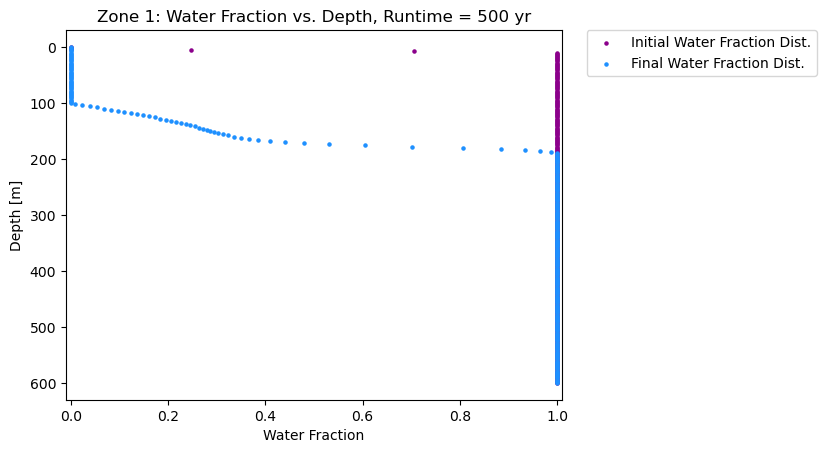

In [18]:
### Fig - Final ice fraction distrubution
#plotting curves for initial and final f_ice distributions

plt.figure()
plt.xlim([-0.01,1.01])
plt.scatter(f_matx_0_1[:,0], z, color='darkmagenta', label='Initial Water Fraction Dist.', s=5)
#plt.scatter(f_matx_0_1[:,10000], z, color='pink', label='10000 yr', s=5)
#plt.scatter(f_matx_0_1[:,20000], z, color='green', label='20000 yr', s=5)
#plt.scatter(f_matx_0_1[:,30000], z, color='red', label='30000 yr', s=5)
#plt.scatter(f_matx_0_1[:,40000], z, color='teal', label='40000 yr', s=5)
plt.scatter(f_matx_0_1[:,runtime-1], z, color='dodgerblue', label='Final Water Fraction Dist.', s=5)
plt.gca().invert_yaxis()
plt.xlabel('Water Fraction')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Water Fraction vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### Plotting aggradation rate and depth of PF & FF

In [35]:
TqFF= 240 #K, freezing front temp
Tq_1= 272.15 #not sure what this is
TqPF= 273.15 #permafrost temp
t_intv=1         ### Time interval between columns in T_matx [yr]
nocell_1=nocell-1

Dcol0=0 #not sure what these are 
Dcol1=615
Dcol2=1965
Dcol3=3375
Dcol4=4505
Dcol5=5220
Dcol6=5670
Dcol7=6020
Dcol8=6570
Dcol9=7337.5
Dcol10=8712.5
Dcol11=12305
Dcol12=15000
DcolFar=18000    ### value not used


presentFFdepth = np.empty(nocell)
presentPFdepth = np.empty(nocell)
presentAggrRate = np.empty(nocell)
DtoDF = np.empty(nocell)

presentFFdepth[0]=0
presentPFdepth[0]=0
presentAggrRate[0]=0
DtoDF[0]=0

temp = np.zeros((nocell,runtime))

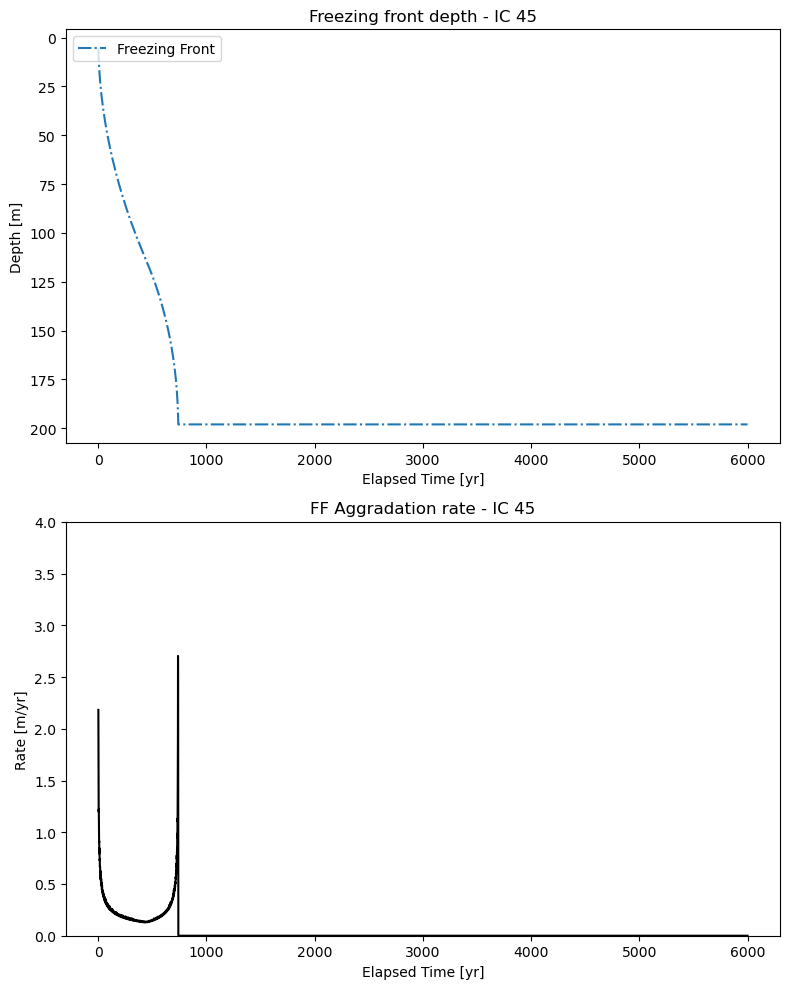

In [43]:
colcount = [1]

for col in colcount:
    if col==1:
        l = runtime  # Runtime [yr]
        k = 0
        zqFF = np.zeros(l)
        zq_1 = np.zeros(l)
        zqPF = np.zeros(l)
        temp = np.zeros((nocell, l))
        tt = np.arange(1, l + 1, t_intv)
        tt_shift = np.arange(1, l, t_intv)
        aggr_rateFF = np.zeros(l-1)
        aggr_rate_1 = np.zeros(l-1)
        aggr_ratePF = np.zeros(l-1)

        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx

            transposed_temp = np.transpose(temp[0:nocell_1, k-1]) # Switches rows and columns
            interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')
            
            if TqFF < np.min(transposed_temp) or TqFF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqFF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqFF)

            zqFF[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if Tq_1 < np.min(transposed_temp) or Tq_1 > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(Tq_1, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(Tq_1)


            zq_1[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if TqPF < np.min(transposed_temp) or TqPF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqPF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqPF)

            zqPF[i] = interpolated_value
            tt[i] = t_intv * k

        colcount[0] += 1
        presentFFdepth[colcount[0]]=zqFF[len(zqFF)-1]
        presentPFdepth[colcount[0]]=zqPF[len(zqPF)-1]
        DtoDF[colcount]=Dcol1

        no_points = len(zqFF)
        tt_shifted = tt - 0.5 * t_intv
        tt_shift[0:(no_points - 1)] = tt_shifted[1:no_points]
        tt_shift_BP = np.flip(tt_shift)
        tt_flip = np.flip(tt)

        for ii in range(len(zqFF)-1):
            aggr_rateFF[ii] = (zqFF[ii + 1] - zqFF[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_rate_1[ii] = (zq_1[ii + 1] - zq_1[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_ratePF[ii] = (zqPF[ii + 1] - zqPF[ii]) / t_intv

        presentAggrRate[colcount]=aggr_rateFF[len(aggr_rateFF)-1]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot the Freezing front and PF depth data in the first subplot
axes[0].plot(tt, zqFF, '-.', label='Freezing Front')
#axes[0].plot(tt, zqPF, '-.', label='Permafrost Front')
axes[0].set_title('Freezing front depth - IC 45')
axes[0].invert_yaxis()
axes[0].set_xlabel('Elapsed Time [yr]')
axes[0].set_ylabel('Depth [m]')
axes[0].legend(loc='upper left')
#axes[0].set_ylim(100, 0)
#axes[0].set_xlim(None,35000)

# Plot the Aggradation rate data in the second subplot
axes[1].plot(tt_shift, aggr_rateFF, 'k')
axes[1].set_title('FF Aggradation rate - IC 45')
axes[1].set_xlabel('Elapsed Time [yr]')
axes[1].set_ylabel('Rate [m/yr]')
#axes[1].set_xlim(0,10000)
axes[1].set_ylim(0,4)
#axes[1].legend(loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
zqFF = 

In [ ]:
print(zqPF)

In [ ]:
T_matx_0_1.to_csv('/Users/alexiakubas/Desktop/Ceres/modelruns/T_HC_45.csv')
f_matx_0_1.to_csv('/Users/alexiakubas/Desktop/Ceres/modelruns/f_HC_45.csv')
k_eq_matx.to_csv('/Users/alexiakubas/Desktop/Ceres/modelruns/k_eq_HC_45.csv')
C_eq_matx.to_csv('/Users/alexiakubas/Desktop/Ceres/modelruns/C_eq_HC_45.csv')
a_eq_matx.to_csv('/Users/alexiakubas/Desktop/Ceres/modelruns/a_eq_HC_45.csv')
zqFF.to_csv('/Users/alexiakubas/Desktop/Ceres/modelruns/zqFF_HC_45.csv')
aggr_rateFF.to_csv('/Users/alexiakubas/Desktop/Ceres/modelruns/aggr_rateFF_HC_45.csv')

## Final PF and FF depths

In [ ]:
plt.plot(DtoDF, presentFFdepth, c='blue', label='Final FF Depth')
plt.plot(DtoDF, presentPFdepth, c='red', label='Final PF Depth')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Depth [m]')
plt.title('Permafrost and freezing front depths')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

## Final Aggradation Rate and Recharge Equivalent

In [ ]:
plt.plot(DtoDF[2:], presentAggrRate[2:], c='blue')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Rate [m/yr]')
plt.title('Aggradation rate and recharge equivalent')

In [ ]:
# next steps: add in temp-dependent material properties? play with diff layers? Investigate FF and PF depths 

## Plotting Final Effective Material Properties 

In [ ]:
print(a_eq_0_1)

In [ ]:
print(C_eq_0_1)

In [ ]:
### Fig - Final effective material property distrubutions
#plotting curves for initial and final effective thermal diffusivity distributions

plt.figure()
#plt.xlim([100,400])
plt.plot(a_eq_0_1, z, linestyle='dashed',color='darkmagenta', label='Final, zone 1')
#plt.plot(a_eq_1_2, z, color='dodgerblue', label='Final, zone 2')
plt.gca().invert_yaxis()
plt.xlabel('Thermal Diffusivity [m^2/s]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Effective Thermal Diffusivity vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [ ]:
### Fig - Final effective material property distrubutions
#plotting curves for initial and final effective heat capacity distributions

plt.figure()
#plt.xlim([100,400])
plt.plot(C_eq_0_1/1e6, z, linestyle='dashed',color='darkmagenta', label='Final, zone 1')
plt.plot(C_eq_1_2/1e6, z, color='dodgerblue', label='Final, zone 2')
plt.gca().invert_yaxis()
plt.xlabel('Heat Capacity [MJ/K]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Effective Heat Capacity vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [ ]:
np.shape(a_eq_0_1)